In [1]:
import sys
sys.path.append("..")   # add the root project folder to the system path variable
from schuberts_leader.core_components import simulate_leading_indicator_data, leading_indicator_miner
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint

Simulate some data for us to use:

( documentation is available using `help(simulate_leading_indicator_data)` )

In [2]:
sim_explain_dict, y_arr, X_arr = simulate_leading_indicator_data(
        n_time_points = 1_000
    ,   n_predictors = 50
    ,   n_leading_indicator_effects = 5
    ,   lagged_effect_time_min_max = (1,10)
    ,   polynomial_coefs_min_max = (
        (-1,1),
        (-0.01,0.01), #(-0.002,0.002),
        (-0.0001,0.0001), #(-0.00002,0.00002),
    )
)
X_varnames = [f"X_{i}" for i in range(X_arr.shape[1])]

Have a look at a (random) few of the simulated leading relationships:

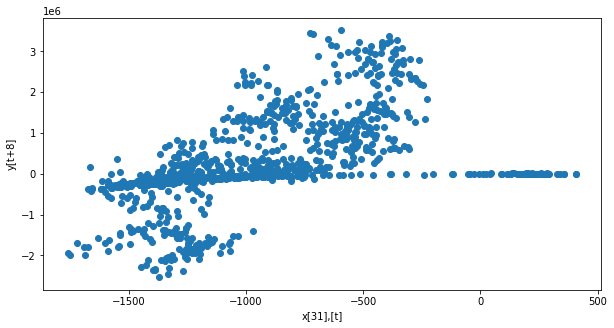

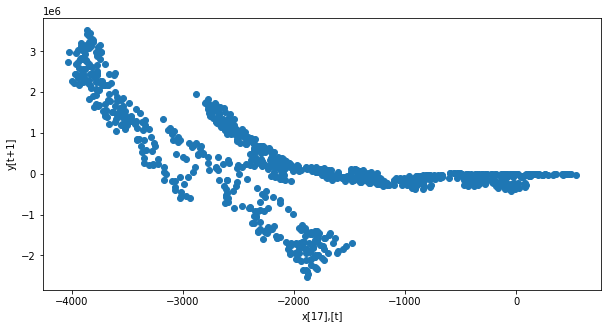

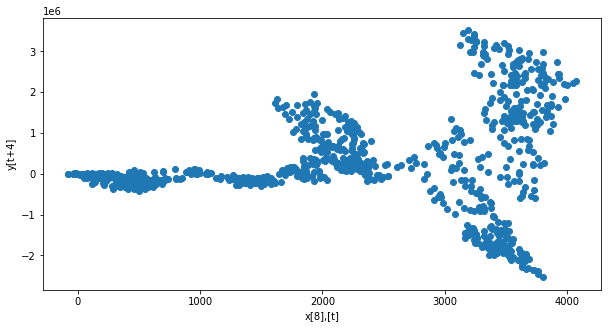

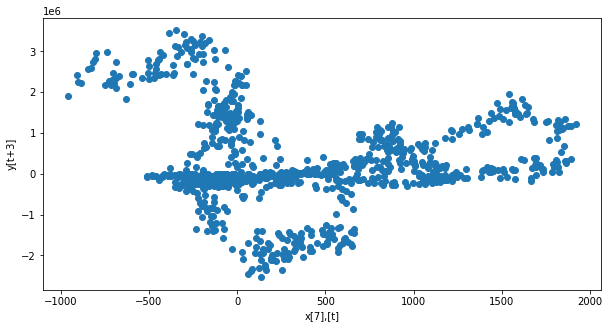

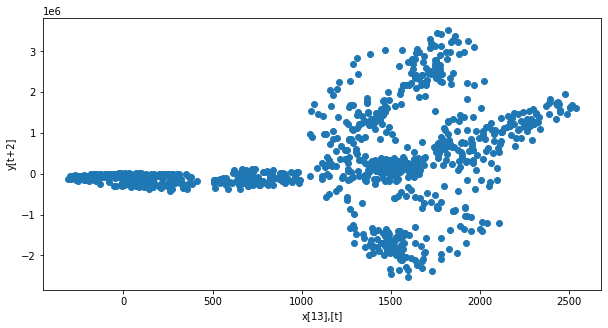

In [3]:
for k in np.random.choice(list(sim_explain_dict.keys()), size=5, replace=False):
    lag_i = sim_explain_dict[k][0]["lag"]
    plt.figure( figsize=(10,5) )
    plt.scatter( X_arr[:(len(X_arr)-lag_i),k], y_arr[lag_i:] )
    plt.xlabel( f"x[{k}],[t]" )
    plt.ylabel( f"y[t+{lag_i}]" )

split the data into a training and a test partition:

In [4]:
test_percent = 0.1
train_idx = ( 0, int((1-test_percent)*len(y_arr))-1 ) 
test_idx = (train_idx[1]+1, len(y_arr))
train_y_arr = y_arr[train_idx[0]:train_idx[1]+1] 
test_y_arr = y_arr[test_idx[0]:test_idx[1]] 
train_X_arr = X_arr[train_idx[0]:train_idx[1]+1,:] 
test_X_arr = X_arr[test_idx[0]:test_idx[1],:]

mine the data for training data for leading indicators:

In [5]:
leading_indicator_miner_model = leading_indicator_miner(n_leading_indicators=5)
leading_indicator_miner_model.fit(
    X = train_X_arr, 
    X_varnames = X_varnames, 
    y = train_y_arr, 
    y_varname = "y", 
    n_iterations = 10_000, 
    n_lags_to_consider = {'min': 1, 'max': 20}, 
    n_knots_to_consider = {'min': 10, 'max': 10}
)

iteration 10,000 of 10,000. best MSE: 219,036,164,438.611

Text(0.5, 1.0, 'Mean Squared Error on Training Data')

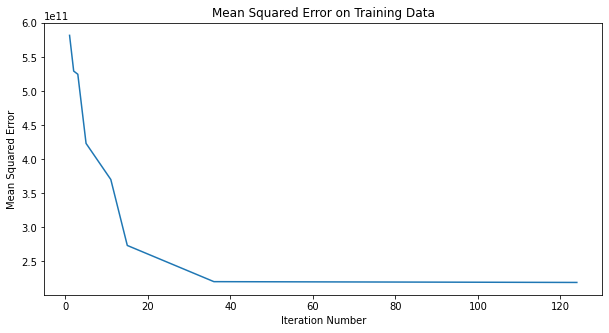

In [6]:
plt.figure( figsize=(10,5) )
plt.plot( 
    [x[0] for x in leading_indicator_miner_model.mse_history],
    [x[1] for x in leading_indicator_miner_model.mse_history],
)
plt.xlabel("Iteration Number")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error on Training Data")

visualize the leading indicators discovered:

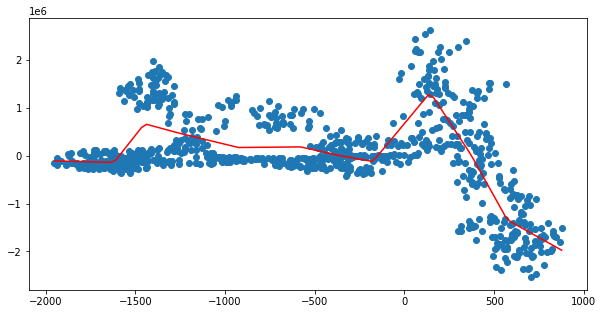

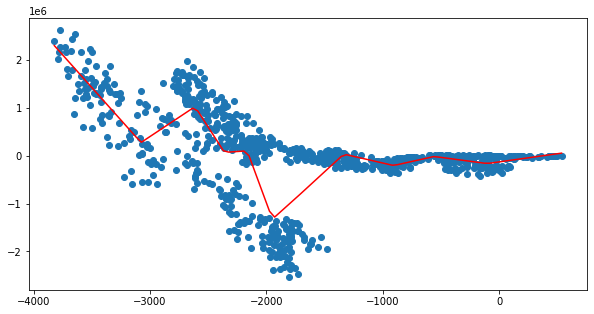

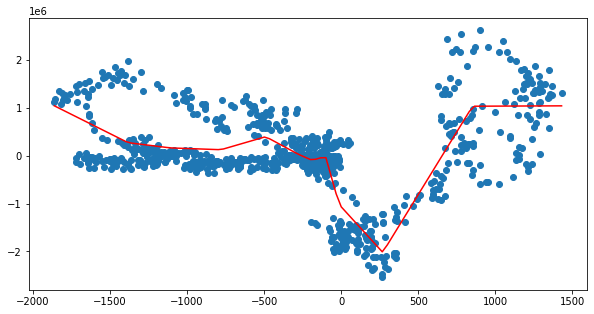

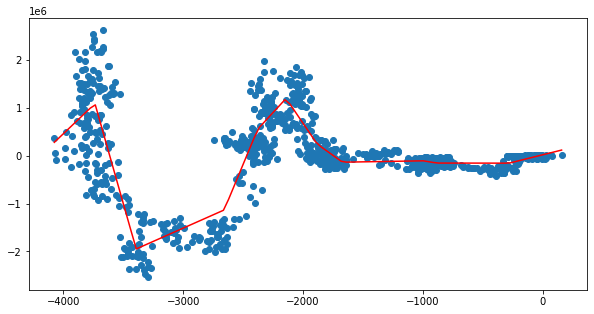

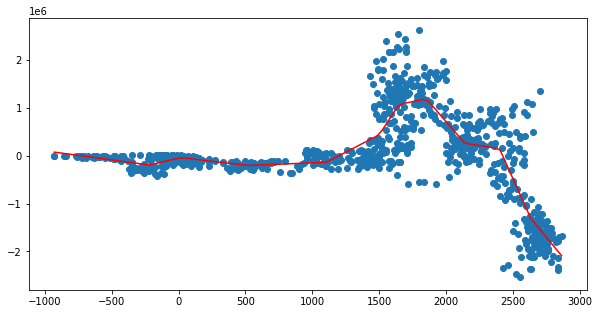

In [7]:
for x in leading_indicator_miner_model.best_leading_indicators_vars_set:
    lag_i = x["lag_n_time_periods"]
    x_vec = train_X_arr[:(len(train_X_arr)-lag_i),X_varnames.index(x["leading_indicator_varname"])]
    y_vec = train_y_arr[lag_i:]
    pred_illus_range = np.linspace(start=x_vec.min(), stop=x_vec.max(), num=100)
    pred_illus_spline_vars = leading_indicator_miner_model.create_linear_splines(X_vec=pred_illus_range, knot_points_list=x["knot_locations"])
    pred_illus_x_matrix = np.column_stack(
                    [np.ones_like(pred_illus_range), pred_illus_range, pred_illus_spline_vars]
                )
    pred_illus_y = leading_indicator_miner_model.generate_linear_model_preds(
                X_matrix=pred_illus_x_matrix,
                beta_coefs_vec=x["beta_coefs"],
            )
    plt.figure( figsize=(10,5) )
    plt.scatter(x_vec, y_vec)
    plt.plot(pred_illus_range, pred_illus_y, color="red")

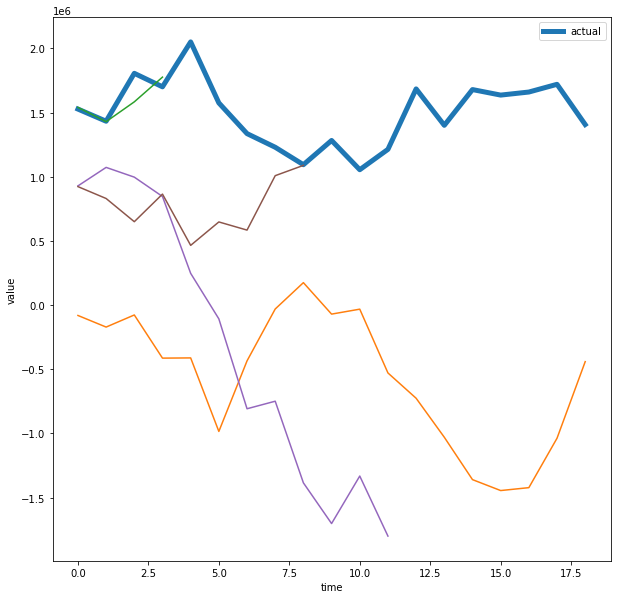

In [8]:
test_forecasts = leading_indicator_miner_model.predict(
    X = train_X_arr, 
    X_varnames = X_varnames
)
max_forecast_length = test_forecasts.shape[0]
plt.figure( figsize=(10,10) )
plt.plot( range(max_forecast_length), test_y_arr[:max_forecast_length], label="actual", linewidth=5 )
for i in range(test_forecasts.shape[1]):
    plt.plot(range(len(test_forecasts[:,i])), test_forecasts[:,i])
plt.xlabel("time")
plt.ylabel("value")
plt.legend()